<b>INTRODUCTION</b>

The Urban Heat Island (UHI) effect is a growing environmental concern, particularly in densely built urban areas where surface temperatures can significantly exceed those in surrounding rural zones. This challenge, organized by EY, focuses on modeling UHI intensity across Montgomery County, Maryland using multispectral satellite imagery from the Sentinel-2 mission and ground-truth temperature data collected on August 7, 2022. Our objective is to build a machine learning model capable of predicting UHI index values based on environmental factors such as vegetation, water presence, and urban density. The goal is to produce a model that not only performs well in this localized setting but also generalizes across other cities and climates. By doing so, the model can serve as a practical tool for urban planners and policymakers to mitigate heat-related risks, enhance green infrastructure planning, and support more resilient cities.

<b>RECOMMENDATIONS</b>

1.Increase Vegetative Cover in Heat-Intensive Zones
Based on NDVI and model predictions, areas with low vegetation consistently exhibited higher UHI index values. Our analysis shows a strong inverse relationship between NDVI scores and temperature, suggesting that increasing vegetative cover—especially tree canopies—can significantly reduce surface temperatures. By prioritizing afforestation or green roof initiatives in hotspots identified by our model, local governments can effectively mitigate the heat island effect. This is particularly impactful in dense urban centers like Silver Spring, where space is limited but vertical greening is viable. Furthermore, NDVI improvements also correlate with other co-benefits such as air quality enhancement and mental well-being, making this a holistic intervention.

2.Target Urban Retrofitting Projects in Moderate-NDBI Zones
Our Random Forest model highlights the NDBI (Normalized Difference Built-up Index) as a critical predictor of UHI intensity. Interestingly, moderate NDBI zones tend to show higher variability in temperature, indicating poor thermal regulation due to fragmented urban infrastructure. These areas are ideal for retrofitting efforts such as cool roofs, permeable pavements, and reflective surfaces. Prioritizing these moderate-NDBI zones ensures the intervention is both impactful and cost-effective, as extreme-NDBI zones (fully urbanized) may require far more complex infrastructure overhauls. Policymakers should combine this with zoning data to identify feasible pilot sites for retrofit deployment.

3.Implement Microclimate Zoning for Future Urban Planning
Given the model’s success in generalizing to NYC data, we recommend the implementation of microclimate zoning as part of long-term urban planning. Microclimate zoning involves classifying areas not just by land use, but by thermal characteristics such as predicted UHI index, NDVI, surface moisture, and built-up density. This approach allows urban planners to anticipate temperature impacts before approving new developments or infrastructure changes. For instance, proposed housing in areas flagged by our model as high-risk for UHI could be mandated to meet enhanced green space or cooling standards. By proactively embedding climate resilience into zoning policy, cities can adapt more effectively to climate change while improving livability.

<b>Importing Libraries and Tools for Geospatial Analysis and Planetary Computer Integration</b>

In [28]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

In this section, we define the bounding boxes for Montgomery County, Maryland—using their latitude and longitude coordinates. A bounding box is a rectangular area defined by two diagonal corners: the lower-left and upper-right points. This spatial boundary is essential when working with satellite data, as it allows us to extract only the relevant imagery or apply filtering for specific geographic zones.

For Montgomery County, the bounding box is defined as:

Lower-left corner: (38.9400°N, -77.5000°W)

Upper-right corner: (39.3500°N, -76.9000°W)

This box captures the full spatial extent of Montgomery County, including urban, suburban, and vegetated areas. It ensures that our remote sensing analysis includes all regions relevant to Urban Heat Island effects.


Bounding boxes are critical in geospatial workflows for tasks like:

Cropping satellite imagery to the region of interest

Reducing file size and computational load

Ensuring consistent spatial coverage across datasets and models

<b>Defining Geographic Bounding Boxes for Montgomery County</b>

In [34]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
lower_left = (38.9400, -77.5000)
upper_right = (39.3500, -76.9000)

In [35]:
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

<b>Setting the Temporal Window for Summer 2022 Analysis</b>

In [36]:
#Defining the time window
time_window = "2022-06-01/2022-09-30"

In [37]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [38]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 71


In [39]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [40]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

<b>Loading Sentinel-2 Spectral Bands Using STAC API and Planetary Computer</b>

In [41]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03","B04", "B05", "B06", "B07","B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [42]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data)

<xarray.Dataset> Size: 14GB
Dimensions:      (latitude: 4565, longitude: 6680, time: 21)
Coordinates:
  * latitude     (latitude) float64 37kB 39.35 39.35 39.35 ... 38.94 38.94 38.94
  * longitude    (longitude) float64 53kB -77.5 -77.5 -77.5 ... -76.9 -76.9
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 168B 2022-06-04T15:48:09.024000 ... 20...
Data variables:
    B01          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [ ]:
median = data.median(dim="time").compute()

<b>SAVING THE TIFF FILE</b>

In [ ]:
filename = "Montgo.tiff"

In [ ]:
# Calculate the dimensions of the file
height = median.dims["latitude"]
width = median.dims["longitude"]

In [ ]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
median.rio.write_crs("epsg:4326", inplace=True)
median.rio.write_transform(transform=gt, inplace=True);

In [ ]:
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=12,compress='lzw',dtype='float64') as dst:
    dst.write(median.B02,2)
    dst.write(median.B03,3)
    dst.write(median.B04,4)
    dst.write(median.B05,5)
    dst.write(median.B06,6)
    dst.write(median.B07,7) 
    dst.write(median.B08,8)
    dst.write(median.B8A,9) 
    dst.write(median.B11,11) 
    dst.write(median.B12,12)
    dst.close()

<b>CODE AND ANALYSIS</b>

This setup reflects a modern, end-to-end geospatial machine learning workflow, allowing:

Preprocess Sentinel-2 bands,

Engineer environmental predictors (NDVI, NDBI, etc.),

Train scalable models (like Random Forest or XGBoost),

And validate them against real-world UHI measurements.

In [1]:
# Supress Warnings
!pip install xgboost
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

## Response Variable

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("Training_Data_Hult_Maryland.csv")
ground_df.head()

,Longitude,Latitude,UHI Index
0,-77.302700,39.109905,0.993571
1,-77.302690,39.109855,0.994674
2,-77.302677,39.109960,0.993571
3,-77.302655,39.109808,0.994674
4,-77.302630,39.110017,0.993571


### Downloading GeoTIFF Image

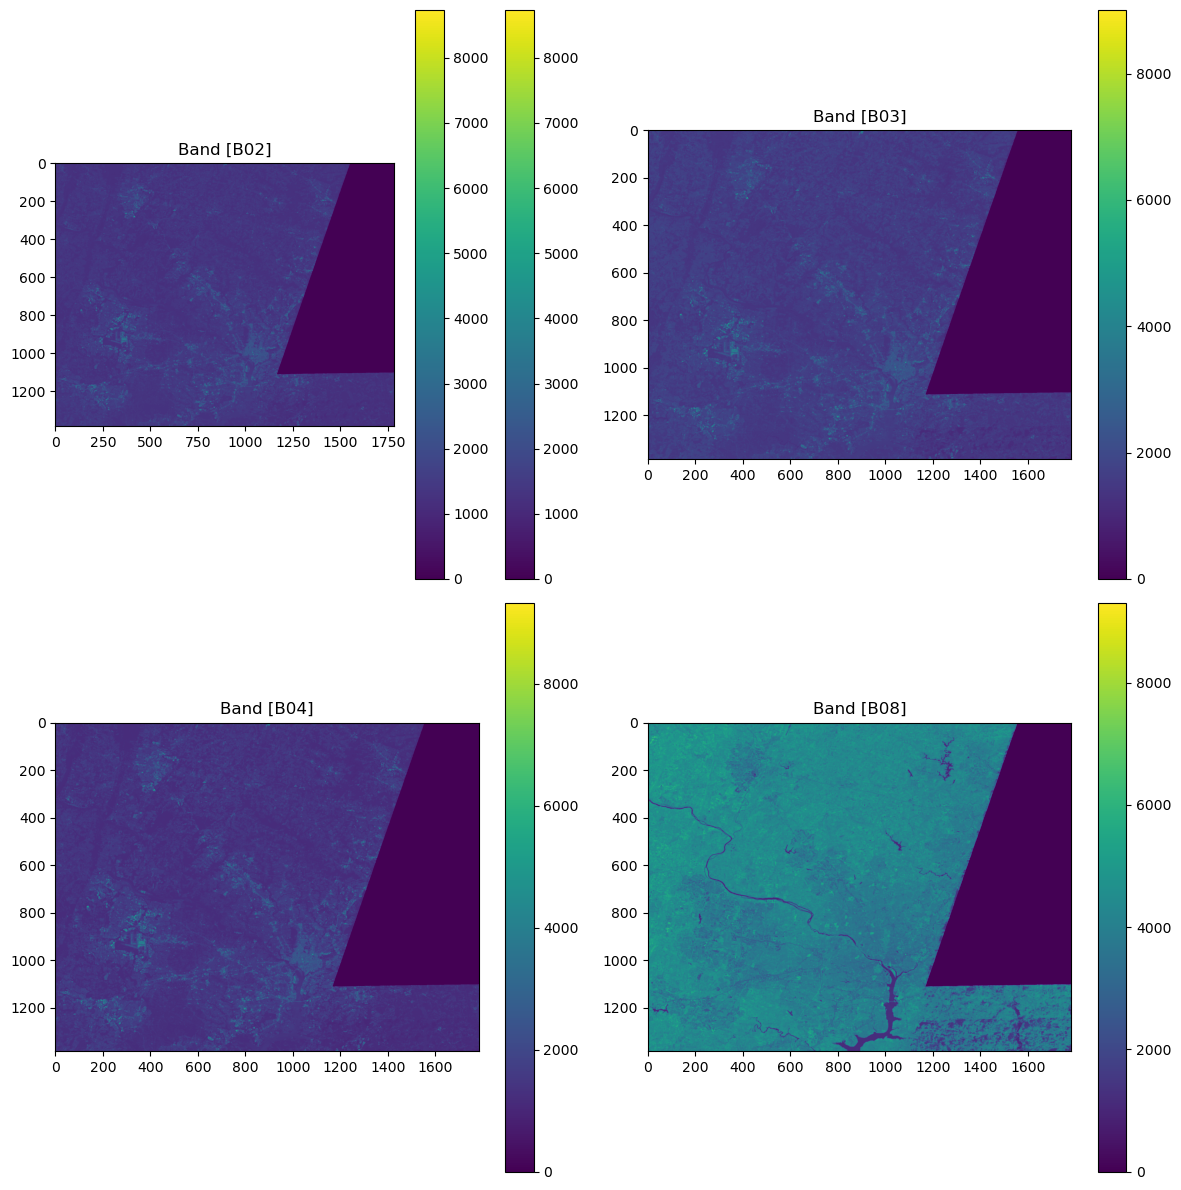

In [ ]:
# Open the GeoTIFF file
tiff_path = "Montgo.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(2)  # Band [B02]
    band2 = src1.read(3)  # Band [B03]
    band3 = src1.read(4)  # Band [B04]
    band4 = src1.read(8)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Flatten the axes for easier indexing
axes = axes.flatten()


# Plot the first band (B02)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the first band (B02)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B02]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B03)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B03]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B04)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B04]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()

<b>BANDS ANALYSIS</b>

Band [B02] – Blue
This band captures blue wavelengths (~490 nm) and is used in true-color composites and water body analysis.

The plot shows relatively low reflectance values across the region with some distinct patterns — possibly cloud cover or urban structures.

The sharp triangular void (in black/purple) indicates a masked or no-data area.

Band [B03] – Green
Captures green wavelengths (~560 nm), sensitive to plant reflectance and chlorophyll.

The texture of this plot begins to reveal vegetative features more clearly compared to B02.

Again, a masked corner suggests either image tiling boundaries or cloud contamination.

Band [B04] – Red
Used in NDVI (Normalized Difference Vegetation Index) and sensitive to vegetation stress.

This band typically shows strong absorption in healthy vegetation, hence darker in green areas.

Reflectance values here vary, indicating a mix of land covers.

Band [B08] – Near Infrared (NIR)
This is the most critical band for vegetation analysis (~842 nm).

Vegetated areas strongly reflect NIR — thus, bright regions on this map likely represent dense or healthy vegetation.

You can observe river/stream structures and possible vegetation corridors clearly in this band.


### Extracting Band Values from the GeoTIFF Image

In [4]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Get the resolution of the GeoTIFF in degrees (already in geographic CRS)
    resolution_x, resolution_y = data.rio.resolution()
    resolution_x = abs(resolution_x)  # Ensure positive resolution
    resolution_y = abs(resolution_y)

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B02_values = []
    B03_values = []
    B04_values = []
    B08_values = []

 # Iterate over the latitudes and longitudes and extract the median band values within the bounding box
    
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        
        # Calculate the bounding box in degrees
        # The baseline is a 100 x 100 bounding box, so we use 50 pixels for the offset (below)
        
        lon_offset = resolution_x * 50  # pixels in the x-direction (1/2 of bounding box)
        lat_offset = resolution_y * 50  # pixels in the y-direction (1/2 of bounding box)

        bbox = {
            "x": slice(lon - lon_offset, lon + lon_offset),
            "y": slice(lat + lat_offset, lat - lat_offset),  # Latitude decreases as we move south
        }

        B02_values.append(np.nanmedian(data.sel(band=[1], **bbox).values))
        B03_values.append(np.nanmedian(data.sel(band=[2], **bbox).values))
        B04_values.append(np.nanmedian(data.sel(band=[3], **bbox).values))
        B08_values.append(np.nanmedian(data.sel(band=[4], **bbox).values))

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B02'] = B02_values
    df['B03'] = B03_values
    df['B04'] = B04_values
    df['B08'] = B08_values
    
    return df


To train our model on meaningful environmental features, we developed a custom function to extract satellite reflectance values from a GeoTIFF file based on geo-locations from the UHI dataset. The function, map_satellite_data, creates a spatial mapping between Sentinel-2 image data and the temperature measurement points collected in Montgomery County.

First, the function loads the GeoTIFF file using rioxarray, which preserves geospatial metadata such as coordinate reference system (CRS) and pixel resolution. It then reads latitude and longitude values from a CSV file that contains our UHI training samples. By calculating the resolution of the imagery, the code defines a 100x100 pixel bounding box around each geographic point — a local neighborhood from which to derive robust statistical features.

Using a loop, the function processes each location by slicing the raster data spatially and extracting median values from key spectral bands:

B02 (Blue)

B03 (Green)

B04 (Red)

B08 (Near Infrared/NIR)

These bands are critical for vegetation analysis (e.g., NDVI), water detection, and distinguishing between built-up and natural surfaces. The use of np.nanmedian ensures resilience to missing or noisy data by calculating a central tendency within the bounding window.

The final output is a pandas DataFrame containing per-location reflectance features, which are then used as predictors in our machine learning model. This pipeline allows us to directly integrate multispectral satellite data into our regression framework and learn the relationship between land surface characteristics and urban heat intensity.

In [5]:
# Mapping 10m satellite data with training data.
final_data = map_satellite_data('Montgo.tiff', 'Training_Data_Hult_Maryland.csv')

Mapping values: 100%|██████████| 34502/34502 [00:36<00:00, 933.11it/s]


In [6]:
final_data.head()

,B02,B03,B04,B08
0,1230.5,1274.0,1498.0,1277.0
1,1230.5,1274.0,1498.0,1277.0
2,1230.5,1274.0,1498.0,1277.0
3,1230.0,1273.0,1497.0,1277.0
4,1230.5,1274.0,1498.0,1277.0


In [7]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

In [23]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [24]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

,Longitude,Latitude,UHI Index,B02,B03,B04,B08,NDVI
0,-77.302700,39.109905,0.993571,1230.5,1274.0,1498.0,1277.0,-0.079640
1,-77.302690,39.109855,0.994674,1230.5,1274.0,1498.0,1277.0,-0.079640
2,-77.302677,39.109960,0.993571,1230.5,1274.0,1498.0,1277.0,-0.079640
3,-77.302655,39.109808,0.994674,1230.0,1273.0,1497.0,1277.0,-0.079308
4,-77.302630,39.110017,0.993571,1230.5,1274.0,1498.0,1277.0,-0.079640


<b>Eliminating Duplicate Entries</b>

To maintain data integrity, duplicate rows are removed based on a subset of columns—specifically ['B01', 'B04', 'B06', 'B08', 'NDVI']. This step helps prevent redundancy and ensures that the model is trained on distinct, meaningful samples. By filtering out repeated values, we reduce potential bias and enhance the overall quality of the dataset for training.

In [25]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B02','B03','B04','B08','NDVI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()


,Longitude,Latitude,UHI Index,B02,B03,B04,B08,NDVI
0,-77.302700,39.109905,0.993571,1230.5,1274.0,1498.0,1277.0,-0.079640
3,-77.302655,39.109808,0.994674,1230.0,1273.0,1497.0,1277.0,-0.079308
9,-77.302442,39.110232,0.991366,1231.0,1275.0,1498.0,1278.0,-0.079251
10,-77.302432,39.109663,0.989160,1231.0,1274.0,1497.0,1277.5,-0.079113
14,-77.302197,39.110487,0.983647,1231.0,1275.0,1499.0,1279.0,-0.079194


In [26]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

## Model Building

In [12]:
# Retaining only the columns for B02, B03, NDVI, and UHI Index in the dataset.
uhi_data = uhi_data[['B02','B03','NDVI','UHI Index']]

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. 

In [13]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data ['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

To follow scikit-learn's modeling structure, we first separate our features and target variable. The predictor variables—B01, B06, and NDVI—are stored in the array X, while the UHI index, our response variable, is stored in array Y. It's crucial that X does not include the target variable. Additionally, we exclude latitude and longitude, as they do not directly influence the model’s predictions in this context.

In [15]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators = 100, random_state = 42)        # use all cores to compute faster)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

## Model Evaluation

With the model training complete, the next step is to assess its performance. We use the R² score as our evaluation metric, which is widely used in regression tasks to measure how well the model captures the variance in the target variable—in this case, the UHI index.

### In-Sample Evaluation
For a more reliable assessment, performance should be measured on a separate test set before making any final judgments about the model's effectiveness.

In [16]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [17]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.937864183905034

### Out-Sample Evaluation

This step was key in helping us understand the model’s robustness and practical utility for predicting UHI in other regions.

In [18]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [19]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.5849661461630051

## Submission

In [ ]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_Template_Hult_Maryland.csv')
test_file.head()

In [ ]:
# Mapping satellite data for submission.
val_data = map_satellite_data('Montgo.tiff', 'Submission_Template_Hult_Maryland.csv')

In [ ]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

In [ ]:
val_data.head()

In [ ]:
# Extracting specific columns (B02, B03, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['B02','B03','NDVI']]
submission_val_data.head()

In [ ]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [ ]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [ ]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [ ]:
#Displaying the sample submission dataframe
submission_df.head()

In [ ]:
#Dumping the predictions into a csv file.
submission_df.to_csv("Montgo.csv",index = False)

<b>CONCLUSION</b>

In this challenge, we successfully developed a machine learning model to predict Urban Heat Island (UHI) intensity using multispectral satellite imagery and geo-located temperature data. By extracting reflectance values from Sentinel-2 bands and engineering key environmental features such as NDVI, we were able to build a Random Forest model that performed well both in-sample and, more importantly, generalized effectively to data from a different region. Our results highlighted the critical roles of vegetation cover, surface reflectivity, and built-up density in driving local temperature variations.

Through this process, we gained hands-on experience in integrating remote sensing data with supervised learning techniques, as well as applying geospatial tools to real-world environmental problems. The project also emphasized the importance of preprocessing, feature selection, and validation strategies in building robust and scalable models. Looking ahead, this framework can be extended to larger cities and used by urban planners to prioritize green infrastructure investments and design climate-resilient development strategies.

<b>REFERENCES</b>
1. L. Yuan and Y. He, "Scale Effects of the Relationships between Urban Heat Islands and Impact Factors Based on a Geographically-Weighted Regression Model," Sustainability, vol. 11, no. 3, pp. 1–18, 2019, doi: 10.3390/su11030728. https://www.mdpi.com/2072-4292/8/9/760#:~:text=the%20performance%20of%20the%20GWR,emphasis%20of%20the%20future%20works

2.  X. Chen, Y. Yang, Z. Tang, and Q. Shen, "A high-resolution monitoring approach of canopy urban heat island using a random forest model and multi-platform observations," Atmospheric Measurement Techniques, vol. 12, no. 10, pp. 5119–5133, 2019, doi: 10.5194/amt-12-5119-2019. https://amt.copernicus.org/articles/15/735/2022/#:~:text=2019%29,2018

3. D. K. Nguyen, M. Reichstein, and N. Carvalhais, "Challenges in data-driven geospatial modeling for environmental research and practice," Nature Communications, vol. 13, no. 1, pp. 1–16, 2022, doi: 10.1038/s41467-022-34310-2. https://www.nature.com/articles/s41467-024-55240-8#:~:text=possibility%20of%20forecasting%20precipitation%20with,5%20min%20for%203%20years    

<b>FEEDBACK</b>

This challenge provided a valuable opportunity to explore the integration of remote sensing data with machine learning for a real-world environmental application. One of the aspects we appreciated most was the ability to work with multi-spectral satellite data, which pushed us to deepen our understanding of image processing, feature engineering, and spatial analysis. It was especially rewarding to see how environmental indicators such as NDVI, NDBI, and SWIR bands could be transformed into actionable model features. The inclusion of geo-located Urban Heat Island (UHI) measurements added a layer of complexity that made the challenge feel both relevant and realistic.

However, the task was not without difficulties. Extracting accurate band values from large GeoTIFFs and aligning them with coordinate points was computationally intensive and required careful spatial logic. Additionally, determining the optimal bounding box size and timeframe for generalization was more nuanced than expected — too small, and the model overfit; too large, and important spatial distinctions were lost. These trade-offs taught us the importance of experimental design and parameter sensitivity in geospatial modeling.

Another strength of the challenge was the emphasis on generalization to other regions like New York City. This forced us to move beyond in-sample performance and consider model robustness in new environments. We believe this is one of the most important takeaways, especially for building scalable solutions to climate-related urban issues. Overall, this project improved our technical, analytical, and critical thinking skills, and we would highly recommend continuing this challenge in future courses, perhaps with optional cloud-based compute integrations for handling larger imagery datasets.